In [15]:
#%load_ext tensorboard
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from glob import glob

from tensorflow.keras import metrics
from tensorflow.keras import optimizers
#from tensorflow.keras.callbacks import TensorBoard


# NOTE jangan di run all karena akan kebuang hasil trainingnya
# ref. https://koushik1102.medium.com/transfer-learning-with-vgg16-and-vgg19-the-simpler-way-ad4eec1e2997
# DATASET
# https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia
# https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Revisi
- Kelas pneumonia dibagi jadi 2, dari virus / bakteri
- Kelas normal masih biasa

In [16]:
IMGSIZE = [224,224]

classes= ["NORMAL","PNEUMONIA_BACTERIAL","PNEUMONIA_VIRAL"]

train = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
).flow_from_directory(
    'train',
    target_size=[224,224],
    batch_size=32,
    class_mode='categorical'
)
val = ImageDataGenerator(
    rescale=1/255,
).flow_from_directory(
    'val',
    target_size=[224,224],
    batch_size=32,
    class_mode='categorical'
)
test = ImageDataGenerator(
    rescale=1/255,
).flow_from_directory(
    'train',
    target_size=[224,224],
    batch_size=32,
    class_mode='categorical'
)




Found 9886 images belonging to 3 classes.
Found 174 images belonging to 3 classes.
Found 9886 images belonging to 3 classes.


In [17]:
#transfer learning w/ vgg19
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=IMGSIZE + [3])

for vgg_layer in vgg19.layers:
    vgg_layer.trainable = False

x = Flatten()(vgg19.output)
pred = Dense(3, activation='softmax')(x)
model = Model(inputs=vgg19.input, outputs=pred)

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [18]:
opt= optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',  metrics=['categorical_crossentropy','accuracy'], optimizer=opt)
results = model.fit(
    train,
    validation_data=val,
    epochs=200,
    batch_size=64,
    callbacks=EarlyStopping(monitor='categorical_crossentropy',patience=3)
)






Epoch 1/200
309/309 [==============================] - 90s 288ms/step - loss: 0.5791 - categorical_crossentropy: 0.5791 - accuracy: 0.7485 - val_loss: 0.9326 - val_categorical_crossentropy: 0.9326 - val_accuracy: 0.5517
Epoch 2/200
309/309 [==============================] - 85s 276ms/step - loss: 0.4543 - categorical_crossentropy: 0.4543 - accuracy: 0.8080 - val_loss: 0.9374 - val_categorical_crossentropy: 0.9374 - val_accuracy: 0.5172
Epoch 3/200
309/309 [==============================] - 85s 276ms/step - loss: 0.4237 - categorical_crossentropy: 0.4237 - accuracy: 0.8241 - val_loss: 0.9552 - val_categorical_crossentropy: 0.9552 - val_accuracy: 0.5460
Epoch 4/200
309/309 [==============================] - 85s 274ms/step - loss: 0.4060 - categorical_crossentropy: 0.4060 - accuracy: 0.8274 - val_loss: 0.9120 - val_categorical_crossentropy: 0.9120 - val_accuracy: 0.5057
Epoch 5/200
309/309 [==============================] - 87s 281ms/step - loss: 0.3979 - categorical_crossentropy: 0.3979 

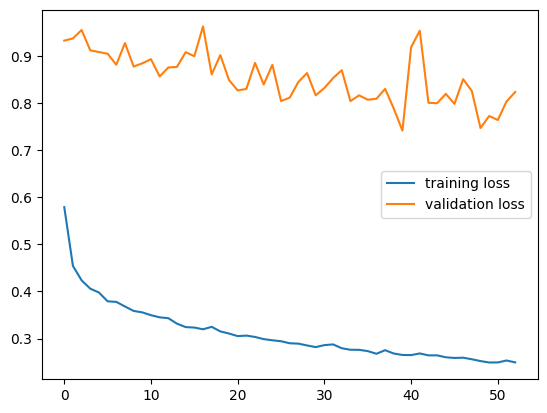

In [19]:
%matplotlib inline

plt.plot(results.history['loss'], label="training loss")
plt.plot(results.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

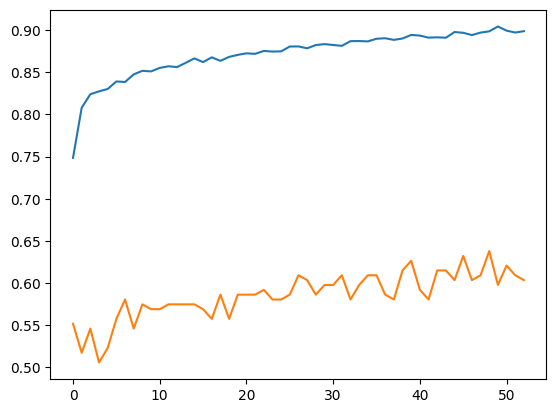

In [20]:
%matplotlib inline

plt.plot(results.history['accuracy'], label="training accuracy")
plt.plot(results.history['val_accuracy'], label="validation accuracy")
plt.show()

In [21]:
model.evaluate(test)

309/309 [==============================] - 42s 137ms/step - loss: 0.2784 - categorical_crossentropy: 0.2784 - accuracy: 0.8733


[0.2784403860569, 0.2784403860569, 0.8732551336288452]

In [22]:
model.save("test_1.h5")